In [3]:
# %matplotlib qt

import os
from tqdm import tqdm
import sys
import cv2
import csv
import scipy as sp
import pdb

sys.setrecursionlimit(5000)  # pour la fonction de contournement recursive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm

import sklearn  # scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans


from skimage.segmentation import clear_border
from skimage.morphology import opening, closing, disk

from skimage import exposure
from skimage.filters import threshold_otsu



'''
An idea to do the segmentation : After use k-means clustering on the whole image so as to differentiate the skin from the nevus.
This would divide the pixels into two clusters. Then I could use sinusoïdale fit with low order regression to get a segmentation of the nevus. 
'''




'\nAn idea to do the segmentation : After use k-means clustering on the whole image so as to differentiate the skin from the nevus.\nThis would divide the pixels into two clusters. Then I could use sinusoïdale fit with low order regression to get a segmentation of the nevus. \n'

In [96]:
def LoadandTreat_images(image_path, mask_path):
    ''' Pour les fichiers possédant déjà un masque dans la database. '''
    image=cv2.imread(image_path,cv2.IMREAD_COLOR)

    ### Apply DullRazor Algorithme to remove hair
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )               # Gray scale
    kernel = cv2.getStructuringElement(1,(20,20)) # (9,9) initialy     # select kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) # Black hat filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)           # Gaussian filter
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)             # Binary thresholding (MASK)
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)                  # Replace pixels of the mask
    
    ### Apply Mask to the image
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

    # Erode the mask to remove all the skin
    kernel = np.ones((15,15),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 1) # erode the mask to remove all the skin on borders, enables better color segmentation
    mask = cv2.erode(mask,kernel,iterations = 1) # additional erosion to remove the skin on the borders

    try :
        image=cv2.bitwise_and(dst,dst,mask=mask)
        # appliquer erosion
    except:
        print(str(mask_path).split('/')[-1])
        print(mask.shape)  # Should print the same shape as 'dst'
        print(str(image_path).split('/')[-1])
        print(dst.shape)
        print(np.unique(mask))  # Should print only 0 and 255
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # permet de convertir l'image en RGB (openCV lie par défaut du BGR)
    return image



def create_nevus_mask(image, dark_threshold=90, show=False):

    pixels = image.reshape(-1, 3)
    height, width = image.shape[:2]

    # Perform k-means clustering with 3 colors
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(pixels)

    # Find the mean color of each cluster
    mean_colors = kmeans.cluster_centers_

    # Check if any of the mean colors is below the dark threshold
    brightness = np.mean(mean_colors, axis=1)
    dark_cluster = brightness < dark_threshold
    plt.imshow(image)
    plt.show()

    if True in dark_cluster:

        # nevus_mask = clear_border(nevus_mask)                                 


        ### We Create a mask to identify non-dark pixels, enableing to be more accurate when segmenting the nevus
        dark_pixels_mask = np.any(image < dark_threshold, axis=2)                    # We take pixels from the dark cluster
        non_dark_pixels_mask = ~dark_pixels_mask                                     # We take the opposite of the dark pixels to get a mask of non dark pixels
        non_dark_pixels_mask = sp.ndimage.binary_fill_holes(non_dark_pixels_mask)    # Fill holes in the non-dark pixels mask, prevent having holes on the nevus area, which can be dark.

        kernel = np.ones((30,30),np.uint8)
        non_dark_pixels_mask = non_dark_pixels_mask.astype(np.uint8)  # converting to uint8
        non_dark_pixels_mask = cv2.erode(non_dark_pixels_mask,kernel,iterations = 1) # we erode the mask to remove some skin on the borders, prevents ending with a large ring of skin when segmenting the nevus
        non_dark_pixels_mask = non_dark_pixels_mask.astype(bool)      # converting back to boolean
        if show :
            print('Dark cluster found')
            plt.imshow(non_dark_pixels_mask)
            plt.title("Non-dark pixels mask")
            plt.show()
        non_dark_pixels = pixels[non_dark_pixels_mask.flatten()]                     # Extract non-dark pixels

        ### Do the clustering on the non-dark pixels only
        kmeans = KMeans(n_clusters=2, random_state=42)                # ! k-means clustering with 2 colors is much more accurate without dark pixels
        kmeans.fit(non_dark_pixels)                                   # !
        if show:
            cluster_img_1 = np.zeros_like(pixels) # Plot the clusters for each label separately
            cluster_img_2 = np.zeros_like(pixels)
            cluster_img_1[non_dark_pixels_mask.flatten()] = (kmeans.labels_ == 0).astype(int)[:, None] * [0,0,255] # one cluster in blue
            cluster_img_2[non_dark_pixels_mask.flatten()] = (kmeans.labels_ == 1).astype(int)[:, None] * [255,0,0] # the other in red
            cluster_img_1 = cluster_img_1.reshape((height, width, 3)) # Reshape the flattened cluster image back to the original image dimensions (height, width, 3)
            cluster_img_2 = cluster_img_2.reshape((height, width, 3))
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("K-means Cluster Label 0")
            plt.imshow(cluster_img_1)
            plt.subplot(1, 2, 2)
            plt.title("K-means Cluster Label 1")
            plt.imshow(cluster_img_2)
            plt.show()
        
        ### We calculate the centers of the clusters and the mean distances of the pixels to the centers in order to differentiate the nevus from the skin
        ### The idea is to find the cluster which is nearer to it's own center
        centers = np.zeros((2, 2))  # store the centers
        mean_distances = np.zeros(2)  # store the mean distances
        pctg = 0.005
        for i in range(2):
            # Get the coordinates of the pixels in this cluster
            local_mask = np.zeros(height * width, dtype=bool)                  # Initialize a full-sized mask with zeros
            local_mask[non_dark_pixels_mask.flatten()] = (kmeans.labels_ == i) # Update only the positions corresponding to the non-dark pixels, local mask for current cluster
            cluster_mask = local_mask.reshape((height, width))                 # Reshape the mask to the original image dimensions
            coords = np.argwhere(cluster_mask)

            # Randomly select a poourcentage of the pixels (fasten the computation)
            num_pixels = coords.shape[0]
            num_sample = int(num_pixels * pctg)
            indices = np.random.choice(num_pixels, num_sample, replace=False)
            sample_coords = coords[indices]

            # Compute the mean of the sample coordinates
            centers[i] = sample_coords.mean(axis=0)
            if show:
                plt.scatter(centers[i][1], centers[i][0])
                plt.scatter(sample_coords[:, 1], sample_coords[:, 0], s=1)

            # Compute the distance between the center and each sample point
            distances = np.sqrt(np.sum((sample_coords - centers[i])**2, axis=1))
            # Compute the mean of the distances
            mean_distances[i] = distances.mean()
        
        if show:
            plt.title("Cluster Centers and Sample Points to determine the inner cluster")
            plt.show()

        nevus_label = np.argmin(mean_distances)          # Assume the nevus is the cluster with the smallest mean distance to its center

        ### We put the non-dark pixels back to their original position in the image
        labels = kmeans.labels_
        full_mask = non_dark_pixels_mask.flatten()
        full_mask[full_mask] = (labels == nevus_label)   # assign the cluster whose points are the closest to its center
        nevus_mask = full_mask.reshape((height, width))  # Reshape the mask to the image dimensions


    else: # here we use a much simpler technique, assuming that ther is enough skin so that the nevus is the least common color, since there are no dark cluster.
        kmeans = KMeans(n_clusters=2) # perform k-means clustering with 2 colors on the whole image
        kmeans.fit(pixels)

        centers = np.zeros((2, 2))
        mean_distances = np.zeros(2)
        pctg = 0.005
        for i in range(2):
            # Get the coordinates of the pixels in this cluster
            cluster_mask = (kmeans.labels_ == i).reshape(height, width)  # Create a mask for the current cluster
            coords = np.argwhere(cluster_mask)

            # Randomly select a percentage of the pixels (fasten the computation)
            num_pixels = coords.shape[0]
            num_sample = int(num_pixels * pctg)
            indices = np.random.choice(num_pixels, num_sample, replace=False)
            sample_coords = coords[indices]

            # Compute the mean of the sample coordinates
            centers[i] = sample_coords.mean(axis=0)

            # Compute the distance between the center and each sample point
            distances = np.sqrt(np.sum((sample_coords - centers[i])**2, axis=1))
            # Compute the mean of the distances
            mean_distances[i] = distances.mean()

        nevus_label = np.argmin(mean_distances)  # Assume the nevus is the cluster with the smallest mean distance to its center
        nevus_mask = (kmeans.labels_ == nevus_label).reshape(height, width)  # Create a binary mask for the nevus
    
    if show:
        plt.title("Nevus Mask, before keeping the largest component")
        plt.imshow(nevus_mask)
        plt.show()

    # Fill holes in the binary image
    nevus_mask = sp.ndimage.binary_fill_holes(nevus_mask)
    
    ### Keep only the largest connected component
    labeled_mask, num_features = sp.ndimage.label(nevus_mask)
    sizes = np.bincount(labeled_mask.ravel())
    sizes[0] = 0  # background is considered as a component, we ignore it
    largest_label = sizes.argmax()
    largest_component = (labeled_mask == largest_label)

    # Remove small dots
    # selem = disk(2)
    # nevus_mask = opening(largest_component, selem)

    return largest_component



def create_and_apply_mask(image, dark_threshold=90):
    
    ### Apply DullRazor Algorithme to remove hair
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )               # Gray scale
    kernel = cv2.getStructuringElement(1,(15,15)) # (9,9) initialy     # select kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) # Black hat filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)           # Gaussian filter
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)             # Binary thresholding (MASK)
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)                  # Replace pixels of the mask

    ### create and apply Mask to the image
    mask = create_nevus_mask(dst, dark_threshold=dark_threshold, show=True)
    mask_uint8 = (mask * 255).astype(np.uint8)
    masked_image = cv2.bitwise_and(dst, dst, mask=mask_uint8)

    return masked_image



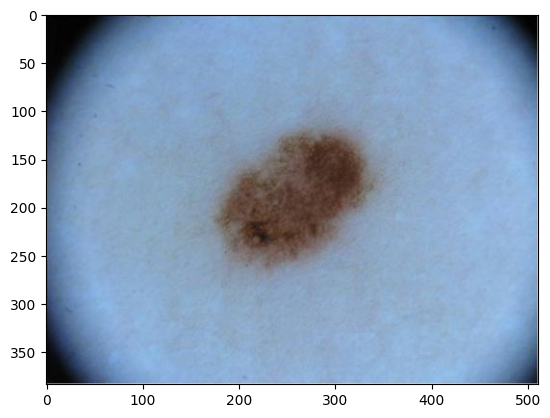

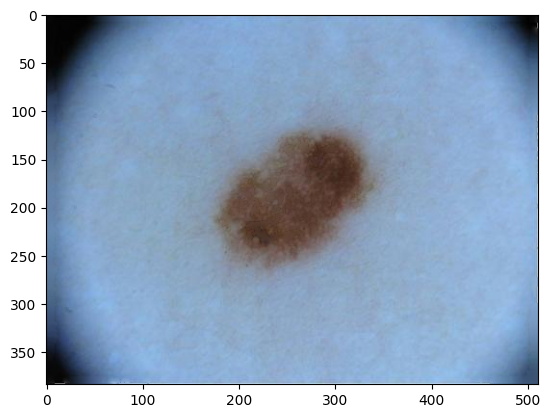

Dark cluster found


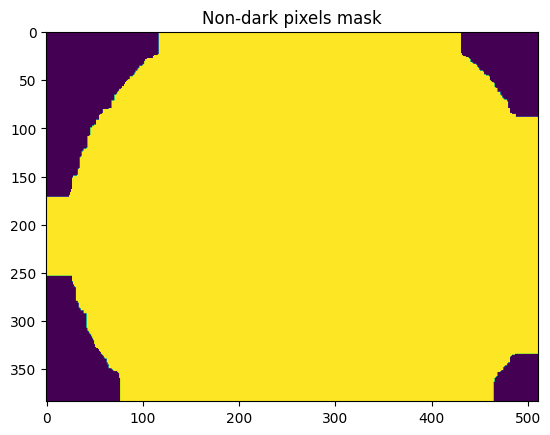

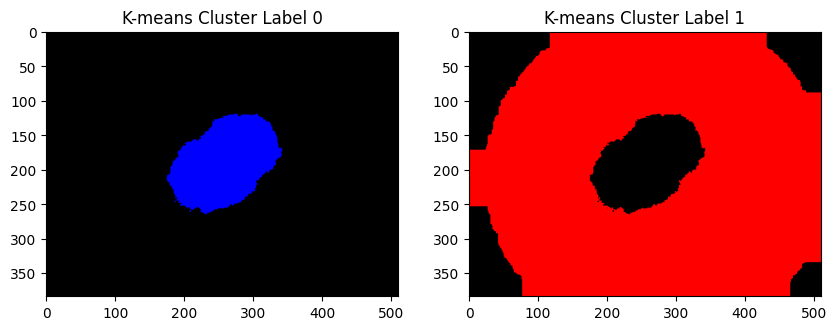

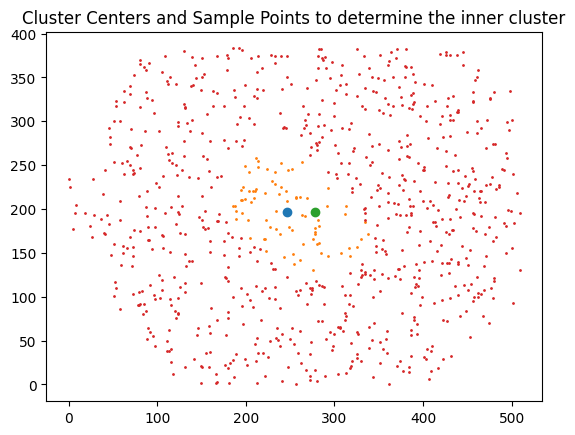

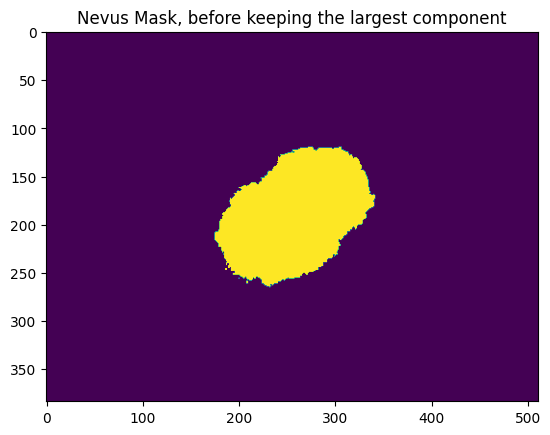

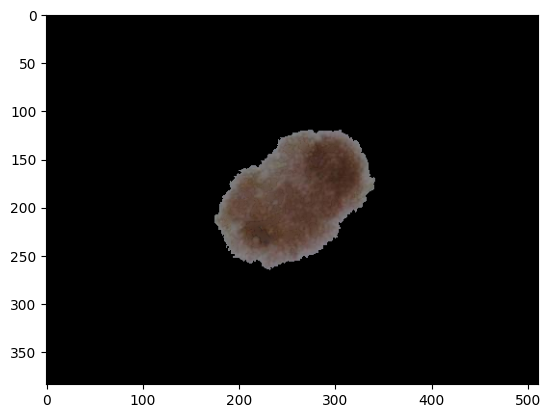

In [99]:
###################### TEST SEGMENTATION ######################

train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Test'

train_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Mask'
test_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Mask'

pourcentage = 0.01
l_dir_test_complet = os.listdir(test_path)
l_dir_test_mask = os.listdir(test_mask_path)
n_test_mask = len(l_dir_test_mask)
l_dir_test_mask = l_dir_test_mask[:int(n_test_mask*pourcentage)]


l_dir_train_complet = os.listdir(train_path)
l_dir_train_mask = os.listdir(train_mask_path)
n_train_mask = len(l_dir_train_mask)
l_dir_train_mask = l_dir_train_mask[:int(n_train_mask*pourcentage)]

image_path1 = os.path.join(train_path, l_dir_train_complet[5])   # weird : 3003, -5, -6 (reverse); -8, 
image = cv2.imread(image_path1, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

masked_image = create_and_apply_mask(image, dark_threshold=90)

plt.imshow(masked_image)
plt.show()



In [23]:
### Importing Dataset ###
train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Test'

train_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Mask'
test_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Mask'

pourcentage = 1
l_dir_test_complet = os.listdir(test_path)
l_dir_test_mask = os.listdir(test_mask_path)
n_test_mask = len(l_dir_test_mask)
l_dir_test_mask = l_dir_test_mask[:int(n_test_mask*pourcentage)]


l_dir_train_complet = os.listdir(train_path)
l_dir_train_mask = os.listdir(train_mask_path)
n_train_mask = len(l_dir_train_mask)
l_dir_train_mask = l_dir_train_mask[:int(n_train_mask*pourcentage)]
# l_dir_train_mask = l_dir_train_mask[430:450]

# region : Ces deux boucles for permettent de ne séléctionner que les images qui ont un mask correspondant
## Je n'arrive pas à faire de masks pour le moment donc je me contente de ceux qui étaient déjà fournis
l_dir_train = []
l_dir_test = []
i_train = 0
for file_name in tqdm(l_dir_train_mask):
    numero_mask  = file_name.split('_')[1]
    numero_train = (l_dir_train_complet[i_train].split('_')[1]).split('.')[0]
    while not numero_mask == numero_train:
        i_train += 1
        numero_train = (l_dir_train_complet[i_train].split('_')[1]).split('.')[0]
    l_dir_train.append(l_dir_train_complet[i_train])

i_test = 0
for file_name in tqdm(l_dir_test_mask):
    numero_mask  = file_name.split('_')[1]
    numero_test = (l_dir_test_complet[i_test].split('_')[1]).split('.')[0]
    while not numero_mask == numero_test:
        i_test += 1
        numero_test = (l_dir_test_complet[i_test].split('_')[1]).split('.')[0]
    l_dir_test.append(l_dir_test_complet[i_test])
# endregion


train_images_path = [os.path.join(train_path, fn) for fn in l_dir_train]
test_images_path = [os.path.join(test_path, fn) for fn in l_dir_test]

train_masks_paths = [os.path.join(train_mask_path, mask_name) for mask_name in l_dir_train_mask]
test_masks_paths = [os.path.join(test_mask_path, mask_name) for mask_name in l_dir_test_mask]

# These two lines return list of masked and hair removed images
test_images = [LoadandTreat_images(image_path, mask_path) for image_path, mask_path in tqdm(zip(test_images_path, test_masks_paths))]
train_images = [LoadandTreat_images(image_path, mask_path) for image_path, mask_path in tqdm(zip(train_images_path, train_masks_paths))]




100%|██████████| 648/648 [00:00<00:00, 650528.72it/s]
648it [01:57,  5.52it/s]
1945it [05:32,  5.85it/s]


In [192]:
### Importing Dataset ###
train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\Test\Test'

pourcentage = 0.01    # 34 et 104 avec 0.005
l_dir_test = os.listdir(test_path)
l_dir_test_mask = [name for name in l_dir_test if 'seg' in name]
n_test = len(l_dir_test)
l_dir_test = l_dir_test[:int(n_test*pourcentage)]

l_dir_train= os.listdir(train_path)
l_dir_train_mask = [name for name in l_dir_train if 'seg' in name]
n_train = len(l_dir_train)
l_dir_train = l_dir_train[:int(n_train*pourcentage)]

def load_and_mask_nevus(l_dir, l_dir_masks, path, dark_threshold=80, show = False):
    l_segmented_images = []
    l_dir_masks_copy = l_dir_masks.copy()

    for i in range(len(l_dir)):
        image_path = os.path.join(path, l_dir[i])
        image=cv2.imread(image_path,cv2.IMREAD_COLOR)
        if show:
            plt.imshow(image)
            plt.show()
        
        name = image_path.split('\\')[-1]
        ID = name.split('.')[0].split('_')[1]
        if 'seg' not in name:
            mask_ID = l_dir_masks_copy[0].split('_')[1]
            if ID == mask_ID :
                mask_path = os.path.join(path, l_dir_masks_copy[0])
                l_dir_masks_copy.pop(0)
                image = LoadandTreat_images(image_path, mask_path)
            else:
                image = create_and_apply_mask(image, dark_threshold=dark_threshold)
        
            l_segmented_images.append(image)

    return l_segmented_images









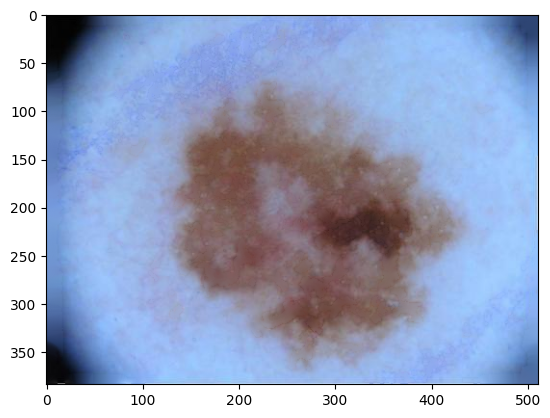

[False  True False]
Dark cluster found


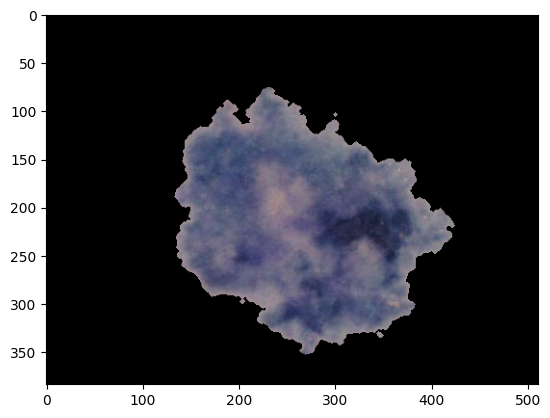

In [204]:
images = load_and_mask_nevus(l_dir_train[:8],l_dir_train_mask , train_path, dark_threshold=100, show = False)
plt.imshow(images[2])
plt.show()

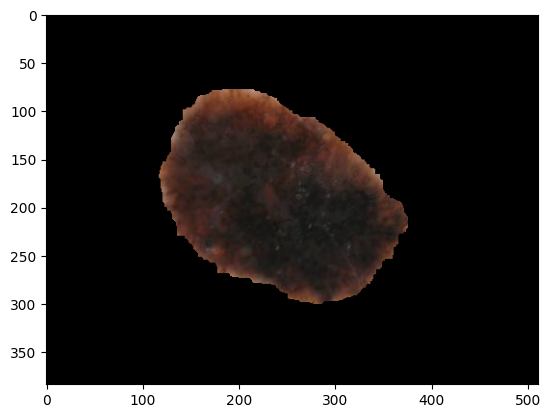

Indicateur de variété des couleurs : 0.11800806421265607
Ecart-type des couleurs de base : [27.70284883 18.06491684 14.73222273]
Asymétrie : 0.050137211225587223
Irrégularité du contour : 0.13975377590117408
Distance moyenne au centre : 111.96743701341258


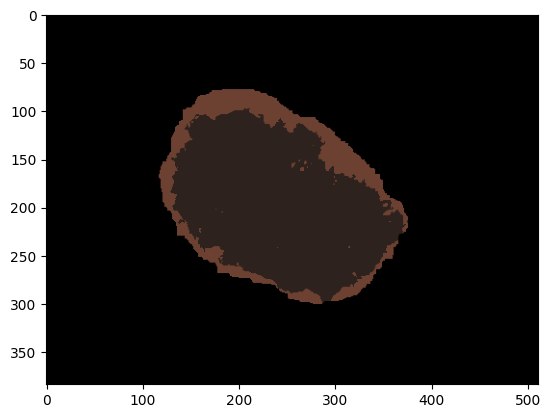

In [24]:
'''
C : Colors
D : Dimension of the lesion
A : Asymmetry
B : Border Irregularity
'''
# Exemple avec plusieurs couleurs sur l'image ISIC_000060.jpg, indice 14 je crois bien

def count_colors_proportion(image, bt=15):
    colors = []
    proportions = []
    h, w, _ = image.shape
    size = h * w
    for i in range(h):
        for j in range(w):
            pixel = image[i, j]
            color = pixel.tolist()
            if color in colors:
                proportions[colors.index(color)] += 1
            else:
                colors.append(color)
                proportions.append(1)

    # On met la couleur noir à 0
    for i,color in enumerate(colors):
        R = color[0] ; G = color[1] ; B = color[2]
        if R<bt and G<bt and B<bt:
            colors[i] = [0, 0, 0]
            break
        if i == len(colors)-1:
            print('No black color found in the image !!!!!!!!!!!!')
            exit()
    
    pourcentages = [p / size for p in proportions]
    colorsAndProportions = list(zip(colors, pourcentages))
    return colorsAndProportions, size

def optimize_proportions(p, a=5, b=6):
    '''
    Le but de cette fonction est d'augmenter l'importance des proportions autour de 0.5 par rapport à celles proche de 0 et 1
    Ainsi on augmente l'importance des cas où il y a plusieurs couleurs dominantes.
    '''
    droite = p

    facteur = 1/((a/(a+b))**a * (b/(a+b))**b)
    cloche = facteur * p**a * (1 - p)**b  # cloche, nul et dérivée nulles en 0 et 1, maximum en fonction de a et b valant 1
    previous = 0.4 * cloche + droite

    Y = 10*p**3 - 15*p**4 + 6*p**5
    return Y

def voisinnage(image, i, j, large=True):
    '''
    Cette fonction permet de récupérer les pixels voisins d'un pixel
    - si large est True, on récupère les 8 voisins (couronne)
    - si large est False, on récupère les 4 voisins (NSEW)
    '''
    i_image = len(image)
    j_image = len(image[0])
    voisins = []
    if i > 0:
        voisins.append((i-1,j))
        if j > 0 and large:
            voisins.append((i-1,j-1))
        if j < j_image-1 and large:
            voisins.append((i-1,j+1))
    if i < i_image-1:
        voisins.append((i+1,j))
        if j > 0 and large:
            voisins.append((i+1,j-1))
        if j < j_image-1 and large:
            voisins.append((i+1,j+1))
    if j > 0:
        voisins.append((i,j-1))
    if j < j_image-1:
        voisins.append((i,j+1))
    return voisins




def is_in_contour(image, i, j):
    '''
    Cette fonction permet de savoir si un pixel est dans le contour d'un nevus
    On regarde les voisins, si un voisin est noir ou que le pixel est sur le bord de l'image,
    alors le pixel est dans le contour.
    '''
    pixel = list(image[i,j])
    if (pixel != [0,0,0]) :
        voisins = voisinnage(image, i, j, large=True)
        for voisin in voisins:
            # On regarde si le voisin est noir ou s'il est sur le bord de l'image (à ce moment là la fonction voisinnage renvoie moins de 8 voisins)
            if ((list(image[voisin[0],voisin[1]]) == [0,0,0]) or len(voisins) < 8) :
                return True
    return False

def contourner(image, i, j, contour):
    '''
    Cette fonction récursive permet de contourner un nevus
    '''
    voisins = voisinnage(image, i, j, large=False)
    to_check = []
    for voisin in voisins:
        i_v, j_v = voisin
        if (voisin not in contour)    and    (list(image[i_v,j_v]) != [0,0,0])    and    (is_in_contour(image, i_v, j_v)):
            contour.append((i_v, j_v))  # on ajoute le pixel au contour (on inverse les coordonnées pour avoir (i,j) et non (j,i) comme dans les images)
            contourner(image, i_v, j_v, contour)
    return contour

def contour_nevus(image, nevus):
    contour = []
    for i in nevus[0]:
        for j in nevus[1]:
            if list(image[i,j]) != [0,0,0]: # on trouve le premier pixel coloré, il appartient forcement au contour
                contour.append((i,j))
            if len(contour) > 0:            # dès qu'on a trouvé le premier élément, on entame le contournement
                contour = contourner(image, i, j, contour) # on entre dans la fonction récursive
                return contour

def trier_contour(image, contour):
    '''
    Cette fonction permet de trier les points du contour dans l'ordre de parcours
    '''
    contour_trie = [contour[0]]
    tampon = []
    k_t = 0
    
    for k,point in enumerate(contour):

        i_t,j_t = contour_trie[k_t]
        voisins = voisinnage(image, i_t, j_t)
        if point in voisins:
            contour_trie.append(point)
            k_t += 1
        else:
            tampon.append(point)
        
        for point_t in tampon:
            i_t,j_t = contour_trie[k_t]
            voisins = voisinnage(image, i_t, j_t)
            if point_t in voisins:
                contour_trie.append(point_t)
                k_t += 1
                tampon.remove(point_t)
    return contour_trie

def contour_naif(image, nevus):
    contour = []
    m = len(image)
    n = len(image[0])
    for i in range(m):
        for j in range(n):
            if is_in_contour(image, i, j):
                contour.append((i,j))
    return contour





def ColorAndDimension(image, n_colors, max_hole_size=100):
    """Cette fonction permet de segmenter une image en fonction de ses couleurs dominantes et d'extraire des indicateurs.
    - On extrait les couleurs dominantes avec un k-means clustering, 
    - On remplit les trous de l'image pour chaque couleur dominante,
    - On superpose les images remplies pour obtenir une image segmentée.
    Après cela on calcule un indicateur rendant compte de la variété des couleurs dominantes.

    Args:
        image (numpy array): Image à segmenter
        n_colors (int): Correspond au nombre de couleurs dominantes à extraire on en extrait généralement 3 (noire, couleur1, couleur2)
        max_hole_size (int, optional): Taille au dela de laquelle on ne remplit pas les trous de l'image (éviter de recouvrir les autres couleurs internes). Defaults to 100.

    Returns:
        tuple of float: image segmentée, couleurs dominantes, (indicateur de variété des couleurs, écart type des couleurs de base), taille de l'image
    """
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)
    stdrd_deviation = np.sqrt(np.var(pixels, axis=0)) # Compute the standard deviation of each color channel
    # Perform k-means clustering to find the most dominant colors
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    # Replace each pixel with its nearest color
    segmented_image = kmeans.cluster_centers_[kmeans.labels_]
    segmented_image = segmented_image.reshape(image.shape).astype(np.uint8)
    # Compute the mean color of each cluster
    mean_colors = kmeans.cluster_centers_.astype(np.uint8)

    filled_labels = np.zeros_like(kmeans.labels_)
    filled_images = np.zeros_like(image)
    areas = []
    # Create a binary image for each color area and stack them in the good order to fill the holes
    for i in range(n_colors):
        binary_image = (kmeans.labels_ == i).reshape(image.shape[:2])
        filled_image = sp.ndimage.binary_fill_holes(binary_image).astype(int)
        areas.append((i, np.sum(filled_image)))

    # Sort the areas in decreasing order of their sizes
    areas.sort(key=lambda x: x[1], reverse=True)
    
    # Apply the colors in the order of the areas
    total_area = len(pixels)
    for i, _ in areas:
        binary_image = (kmeans.labels_ == i).reshape(image.shape[:2])
        filled_image = sp.ndimage.binary_fill_holes(binary_image).astype(int)
        filled_images[filled_image == 1] = mean_colors[i]
        filled_labels[filled_image.flatten() == 1] = i

    colorsAndProportions, size = count_colors_proportion(filled_images)  # TODO: perte de temps ici, c'est le plus simple pour le moment

    #### ! Computing indicators to be returned ####
    black_index = colorsAndProportions[:][0].index([0, 0, 0])
    black_proportion = colorsAndProportions[black_index][1]
    non_black_proportion = 1 - black_proportion
    colorsAndProportions.pop(black_index)  # remove the black color
    colors = [color for color, _ in colorsAndProportions]

    # Computing the distance between the two most dominant colors
    R1, G1, B1 = colorsAndProportions[0][0]  ; pctg1 = colorsAndProportions[0][1]  
    R2, G2, B2 = colorsAndProportions[1][0]  ; pctg2 = colorsAndProportions[1][1]
    distance = np.sqrt((R1 - R2) ** 2 + (G1 - G2) ** 2 + (B1 - B2) ** 2)/255
    
    # Taking into account the proportion of the non black colors
    local_pourcentages = [pctg1/non_black_proportion, pctg2/non_black_proportion]
    min_pourcentage = min(local_pourcentages)
    different_colors_indicator = distance * optimize_proportions(2*min_pourcentage)
    
    return filled_images, colors, (different_colors_indicator,stdrd_deviation), size

def AsymetryAndBorderIrregularity(image, show=False, show_loop=False):
    """Cette fonction calcul l'asymétrie et l'irrégularité du contour d'un nevus
    - asymétrie : moyenne des distances entre les points du contour et leur opposé par rapport au centre de gravité
    - irrégularité : écart-type des distances des points du contour au centre de gravité

    Args:
        image (numpy array): image de travaille en RGB
        show (bool, optional): afficher le calcul de l'irrégularité. Defaults to False.
        show_loop (bool, optional): afficher les images d'asymétrie. Defaults to False.

    Returns:
        tuple: asymétrie_moyenne, irrégularité_bord, distance_moyenne_au_centre
    """
    ## Calculer l'écart-type des distances des pixels du contour au centre de gravité
    non_null_pixels = np.where(np.any(image != [0, 0, 0], axis=-1))
    center = [np.mean(non_null_pixels[0]), np.mean(non_null_pixels[1])]
    
    contour = contour_nevus(image, non_null_pixels) # attention, ici les coordonnées sont inversées si on veut les afficher
    # contour = donner_contour(image, non_null_pixels)    # on récupère les points du contour
    contour = trier_contour(image, contour)           # on trie les points du contour dans l'ordre de parcours
    distances_to_center = [np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2) for i, j in contour]

    mean_distance = np.mean(distances_to_center)
    border_irregularity = np.std(distances_to_center/mean_distance)

    if show:
        # Assume points is your list of points
        points = np.array(contour)
        print(points.shape)
        print(contour[:10])
        # Create a sequence of numbers from 0 to 1
        colors = np.linspace(0, 1, len(points))
        plt.scatter(points[:, 0], points[:, 1], c=colors, cmap='viridis')
        plt.colorbar(label='Color scale')
        plt.show()

        circle = patches.Circle((center[1], center[0]), mean_distance, fill=False, color='red')
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.add_patch(circle)
        plt.show()
    
    
    ## Calculer l'asymétrie
    asymetries = []
    securite = int(len(contour)/3) 
    i_g = center[0]
    j_g = center[1]
    for k1,point1 in enumerate(contour):
        i_1 = point1[0]
        j_1 = point1[1]
        alpha1 = (j_1 - j_g) / (i_1 - i_g)

        delta_alpha_min = 1e15
        k_min = 0
        for k2,point2 in enumerate(contour):  # TODO : Y a probablement moyen de faire plus rapide, en parcourant les points proche de l'opposé.
            i_2 = point2[0]
            j_2 = point2[1]
            alpha2 = (j_2 - j_g) / (i_2 - i_g)
            delta_alpha = abs(alpha1 - alpha2)
            if (delta_alpha < delta_alpha_min)  and   (k2 not in range(k1-securite, k1+securite)): # on enlève le point 1 et ses voisins pour qu'il n'y ait qu'un seul minimum : le point opposé à 1 par rapport au centre
                delta_alpha_min = delta_alpha
                k_min = k2
        
        i_2 = contour[k_min][0]
        j_2 = contour[k_min][1]
        d1 = np.sqrt((i_1 - i_g) ** 2 + (j_1 - j_g) ** 2)
        d2 = np.sqrt((i_2 - i_g) ** 2 + (j_2 - j_g) ** 2)
        asymetry = abs(d1 - d2)/mean_distance
        asymetries.append(asymetry)
        if show_loop:
            plt.imshow(image)
            plt.scatter([j_g], [i_g], c='red')
            plt.scatter([j_1], [i_1], c='blue')
            plt.scatter(contour[k_min][1], contour[k_min][0], c='green')
            plt.show()
    asymetry = np.mean(asymetries)

    return asymetry, border_irregularity, mean_distance


[image,ID] = train_images[8]    # 67 sort de l'image
# print(ID)
plt.imshow(image)
plt.show()
segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
asymetry, border_irregularity, mean_distance = AsymetryAndBorderIrregularity(image)
print('Indicateur de variété des couleurs :', indicator)
print('Ecart-type des couleurs de base :', std)
print('Asymétrie :', asymetry)
print('Irrégularité du contour :', border_irregularity)
print('Distance moyenne au centre :', mean_distance)
plt.imshow(segmented_image)
plt.show()




In [25]:

train_data_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\train_data.csv'
test_data_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\test_data.csv'
errors_train = []
errors_test = []

with open(train_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "indicator", "R1", "G1", "B1", "R2", "G2", "B2", "stdR", "stdG", "stdB", "asymetry", "border_irregularity", "mean_distance"])
    for i,[image, ID] in tqdm(enumerate(train_images[:100])):
        try :
            segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
            asymetry, border_irregularity, mean_distance = AsymetryAndBorderIrregularity(image)
            R1,G1,B1 = colors[0]
            R2,G2,B2 = colors[1]
            stdR,stdG,stdB = std
            writer.writerow([ID, indicator, R1, G1, B1, R2, G2, B2, stdR, stdG, stdB, asymetry, border_irregularity, mean_distance])
        except:
            print("erreur sur l'image", i)
            errors_train.append(i)

with open(test_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", 'indicator', 'R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'stdR', 'stdG', 'stdB', 'asymetry', 'border_irregularity', 'mean_distance'])
    for i,[image, ID] in tqdm(enumerate(test_images[:50])):
        try :
            segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
            asymetry, border_irregularity, mean_distance = AsymetryAndBorderIrregularity(image)
            R1,G1,B1 = colors[0]
            R2,G2,B2 = colors[1]
            stdR,stdG,stdB = std
            writer.writerow([ID, indicator, R1, G1, B1, R2, G2, B2, stdR, stdG, stdB, asymetry, border_irregularity, mean_distance])
        except:
            print("erreur sur l'image", i)
            errors_test.append(i)

print("erreurs sur les images d'entrainement : ", errors_train)
print(" ")
print("erreurs sur les images de test : ", errors_test)


100it [01:14,  1.35it/s]
50it [00:35,  1.43it/s]

erreurs sur les images d'entrainement :  []
 
erreurs sur les images de test :  []


In [26]:
####################### FUNCTIONS ############################################
##############################################################################

def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

def make_labels(labels):
  l_labels = []
  for i in range(len(labels)):
    l_labels.append([])
    for j in range(8):
      if labels[i] == j:
        l_labels[-1].append(1)
      else:
        l_labels[-1].append(0)
  return l_labels


In [28]:
########################### MAIN ##############################################
##############################################################################
body_part = {'nan':0, 'lower extremity':1, 'anterior torso':2, 'head/neck':3, 'posterior torso':4, 'upper extremity':5, 'palms/soles':6, 'oral/genital':7}
sex = {'nan':0, 'female':1, 'male':2}

# Importing the data
train_data = pd.read_csv(train_data_path)
metadata_train = pd.read_csv('metadataTrain.csv')

test_data = pd.read_csv(test_data_path)
metadata_test = pd.read_csv('metadataTest.csv')
test_results = pd.read_csv('SampleSubmission.csv')

# Merge the data
X_train = train_data.merge(metadata_train, left_on='ID', right_on='ID', how='inner')
X_test = test_data.merge(metadata_test, left_on='ID', right_on='ID', how='inner')
X_test = X_test.merge(test_results, left_on='ID', right_on='ID', how='inner')

# Map the 'POSITION' and 'SEX' columns
X_train['POSITION'] = X_train['POSITION'].map(body_part)
X_train['SEX'] = X_train['SEX'].map(sex)
X_test['POSITION'] = X_test['POSITION'].map(body_part)
X_test['SEX'] = X_test['SEX'].map(sex)

# Create the labels
Y_train = X_train['CLASS']
Y_test = X_test['CLASS']

# Drop the 'CLASS' column to create the features
X_train = X_train.drop(['ID','CLASS'], axis=1)
X_test = X_test.drop(['ID','CLASS'], axis=1)

# Drop the headers
print(X_train.head())

# Save the data
train_data_path2 = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\train_data2.csv'
test_data_path2 = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\test_data2.csv'
Y_train.to_csv(train_data_path2, index=False)
Y_test.to_csv(test_data_path2, index=False)

# Convert the data into PyTorch tensors and create a Dataset object
X_train = torch.tensor(X_train.values).float()
Y_train = torch.tensor(Y_train.values).long()
X_test = torch.tensor(X_test.values).float()
Y_test = torch.tensor(Y_test.values).long()


training_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Define the neural network architecture
d_in = X_train.shape[1]  # input dimension
print(d_in)
n_1l = 200  # first layer
n_2l = 200  # second layer
n_3l = 100  # third layer
n_out = len(np.unique(Y_train))  # output dimension

model = nn.Sequential(
    nn.Linear(d_in, n_1l),
    nn.ReLU(),
    nn.Linear(n_1l, n_2l),
    nn.ReLU(),
    nn.Linear(n_2l, n_3l),
    nn.ReLU(),
    nn.Linear(n_3l, n_out)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(12):
    for data, labels in DataLoader(training_dataset, batch_size=10, shuffle=True):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in DataLoader(test_dataset, batch_size=10):
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: %d %%' % (100 * correct / total))

   indicator   R1   G1   B1   R2   G2   B2       stdR       stdG       stdB  \
0   0.232372   98   86   88   55   46   51  37.571461  32.459705  33.909738   
1   0.127299   67   41   32   40   26   22  10.079569   6.334639   5.061833   
2   0.279451  146  102   69   96   59   42  55.075344  37.367574  26.054157   
3   0.291550  193  150  182  190  102  124  85.303007  59.157726  71.180903   
4   0.137604  104   81   71   87   59   47  20.075982  14.784417  12.494286   

   asymetry  border_irregularity  mean_distance  SEX   AGE  POSITION  
0  0.006971             0.004504     170.346793  1.0  55.0       2.0  
1  0.012413             0.009092      46.944728  1.0  30.0       2.0  
2  0.109591             0.084745     125.087209  2.0  30.0       5.0  
3  0.099976             0.132270     128.845078  2.0  80.0       4.0  
4  0.057043             0.217136      54.306165  1.0  25.0       4.0  
16


IndexError: Target 2 is out of bounds.

In [ ]:
# Réseau de neurones qui va prendre en entrée les indicateurs précédement calculé et qui va classer l'image parmie les 8 classes



####################### MAIN #################################################
##############################################################################
n_image_train = len(train_images) # max 18998
n_image_test = len(test_images)   # max 6333
desired_size = (512, 384) # The dimensions of the images in the dataset

l = os.listdir('Train\Mask')  # 1945
print(len(l))
l_test = os.listdir('Test\Mask')  # 648
print(len(l_test))


### Importer les données d'entrainement et les données de test
X_train = [] # Create an empty list to store the images
X_test = [] # Create an empty list to store the images
#region : remplir le vecteur X_train avec les images d'entrainement
image_files_train = os.listdir('Train\Train') # List all the files in the directory
print("Loading training images...")
tiny_train_image_files = image_files_train[:n_images_train] # Take the first 10 files

for image_file in tqdm(tiny_train_image_files): # Loop over the files
    image = Image.open('Train\Train\\' + image_file)
    image = image.resize(desired_size)
    image_np = np.array(image)
    X_train.append(image_np)
#endregion
#region : remplir le vecteur X_test avec les images de test
image_files_test = os.listdir('Test\Test')
print("Loading test images...")
tiny_test_image_files = image_files_test[:n_images_test]
for image_file in tqdm(tiny_test_image_files):
    image = Image.open('Test\Test\\' + image_file)
    image = image.resize(desired_size)  # Resize the image
    image_np = np.array(image)
    X_test.append(image_np)
#endregion
Y_train = [] # Create an empty list to store the labels of training data
Y_test = [] # Create an empty list to store the labels of test data
#region : remplir les vecteur Y_train et Y_test
print("Loading training and test labels...")
data_train = pd.read_csv('metadataTrain.csv')
tiny_data_train = data_train[:n_images_train]
Y_train = tiny_data_train['CLASS'].values        # numpyarray of integers
data_test = pd.read_csv('SampleSubmission.csv')
tiny_data_test = data_test[:n_images_test]
Y_test = tiny_data_test['CLASS'].values
#endregion

X_train = np.array(X_train)
X_test = np.array(X_test)


print("Fin des remplissages des vecteurs")
print("_________________________________")

X_train = np.array(X_train).reshape(len(X_train), -1)
X_test = np.array(X_test).reshape(len(X_test), -1)

training_dataset = TensorDataset(torch.tensor(X_train).float(),torch.unsqueeze(torch.tensor(Y_train),-1).float()) # Creates a pytorch Dataset object
test_dataset = TensorDataset(torch.tensor(X_test).float(),torch.unsqueeze(torch.tensor(Y_test),-1).float()) # Creates a pytorch Dataset object
# so the wall purpose of a dataset is the get_item(i) method, which returns the i-th element of the dataset as a torch tensor
# such dataset are just much easier to manipulate, we'll see why later


### Using GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


### Créer le modèle du Programme de Machine Learning
d_im = desired_size[0]*desired_size[1]*3 # 3 channels for the RGB
# d_im = 3
n_1l = 500
n_2l = 200
n_3l = 100
n_out = 8    # 4 classes as an output

## Let's first try with the sequential API
mon_model = nn.Sequential()
mon_model.add_module('1st_linear_layer', nn.Linear(d_im,n_1l))
mon_model.add_module('relue1', nn.ReLU())
mon_model.add_module('2nd_linear_layer', nn.Linear(n_1l,n_2l))
mon_model.add_module('relue2', nn.ReLU())
mon_model.add_module('3rd_linear_layer', nn.Linear(n_2l,n_3l))
mon_model.add_module('relue', nn.ReLU())
mon_model.add_module('final_linear_layer', nn.Linear(n_3l,n_out))
mon_model = mon_model.to(device)

learning_rate = 0.01
n_epochs = 12
batch_size = 10

## Binary Cross Entropy loss from PyTorch
criterion = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.Adam(mon_model.parameters(), lr = learning_rate)

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=False) # apparently this modifies the dataset to create minibatches inside of it.
test_loader     = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print("Fin de la création du modèle et des variables nécessaires")
print("_________________________________________________________")




####### Entrainement du NN ####################
mon_model.train() # put model in training mode (required as some layers, for instance dropout, have different behavior in training and evaluation mode)

for epoch in range(0,n_epochs): # n_epochs is the number of training iterations
  # Initialize the loss storage to plot it later
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(training_loader, unit="batch") as tepoch: # tepoch is the variable that hold each batch of data as we iterate over training_loader
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put the data on device
      data = data.to(device)
      labels = labels.to(device).squeeze()
      labels = make_labels(labels)
      labels = torch.tensor(labels).float()
      #print(type(labels))
      #print(labels)

      # 1. Do the forward pass : 
      y_predict = mon_model(data)  # performs the forward pass, which computes the predicted outputs by passing inputs to the model.
      # it gets better and better as the training goes on
      print(f"y_predict : {y_predict}")
      print(f"labels : {labels}")
      # 2. Compute the loss :
      # y_predict = torch.argmax(y_predict, dim=1).float() 
      
      loss = criterion(y_predict, labels)  # computes the loss between the predicted and actual labels. And then do the sum I guess
      print(f"loss : {loss}")
      # 3. Reset gradients to 0 : optimizer = optim.Adam(model.parameters(), lr = learning_rate)
      optimizer.zero_grad() # resets the gradients to zero before starting to do backprojections because PyTorch accumulates the gradients on subsequent backward passes.

      # 4. Do the backward pass : 
      loss.backward() # computes the derivative of the loss % to parameters (or anything requiring gradients) using backpropagation.

      # 5. Call the parameter update
      optimizer.step() # causes the optimizer to take a step based on the gradients of the parameters.

      # Compute the loss
      train_loss += loss.item()
      # Store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend((y_predict>=0.5).tolist())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(training_loader.dataset)))
  print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),np.array(all_labels))))

  

mon_model.eval()

all_predicted = []
all_labels = []

with tqdm(test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    all_labels.extend(labels.tolist())

    data = data.to(device)
    y_predict = mon_model(data)
    all_predicted.extend((y_predict>=0.5).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)



In [ ]:
######### retirer les poils #########

#Input image
path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train/Train/ISIC_0000006.jpg'
#Read image
image=cv2.imread(path,cv2.IMREAD_COLOR)

#Image cropping
img=image[30:410,30:560]

#DULL RAZOR (REMOVE HAIR)

#Gray scale
grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
#Black hat filter
kernel = cv2.getStructuringElement(1,(20,20)) # = 9 basicaly
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
#Gaussian filter
bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
#Binary thresholding (MASK)
ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
#Replace pixels of the mask
dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)


#Display images
plt.imshow(image)
plt.show()
plt.imshow(dst)
plt.show()
    


TypeError: 'NoneType' object is not subscriptable